In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"apollopubg","key":"3c6e2519fa3fc29b6143e88f14a90408"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d aftabhussaincui/refined-rnsa-ct-scans-12k-pngs
! unzip refined-rnsa-ct-scans-12k-pngs.zip

In [1]:
import time

import pathlib
import itertools
from glob import glob
from PIL import Image
import os, random, shutil
from random import uniform
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [2]:

from tensorflow.keras.models import Model,load_model, Sequential
from tensorflow.keras.layers import  GlobalAveragePooling2D, Dropout, Dense
import tensorflow as tf
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from IPython.display import SVG
from keras.utils import model_to_dot
from keras.utils import plot_model

In [8]:
dataset_path = 'RNSA_Subset_PNGs_12K'
# ! rm 'RNSA_Subset_PNGs_12K/Meta data.txt'
folders = [os.path.join(dataset_path, folder_name) for folder_name in os.listdir(dataset_path)]

# Initialize empty lists to store the file paths for each set
train_set, validation_set, test_set = [], [], []

# Loop over each folder and split the PNG images into sets
for folder in folders:
    # Get the folder name (label)
    folder_name = os.path.basename(folder)
    # Get a list of all the PNG images in the folder
    png_images = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.png')]
    random.shuffle(png_images)
    # Define the percentage split for train, validation, and test sets
    train_percent, validation_percent, test_percent = 0.75, 0.15, 0.1
    # Split the PNG images into train, validation, and test sets
    num_files = len(png_images)
    train_end = int(num_files * train_percent)
    validation_end = int(num_files * (train_percent + validation_percent))
    train_set += png_images[:train_end]
    validation_set += png_images[train_end:validation_end]
    test_set += png_images[validation_end:]

for directory in ['Train', 'Validation', 'Test']:
    os.makedirs(os.path.join(dataset_path, directory), exist_ok=True)


names = {'Epidural_Positive':"EDH",'Intraparenchymal_Positvie':"IPH",
        'Intraventricular_Positive':"IVH", 'Subarachnoid_Positive':"SAH", 
        'Subdural_Positive':"SDH", "Any_Normal":"Normal"}

# Loop over the train, validation, and test sets, and copy each image to the appropriate directory
for set_name, set_files in [('Train', train_set), ('Validation', validation_set), ('Test', test_set)]:
    for folder_name in [ 'Epidural_Positive','Intraparenchymal_Positvie', 'Intraventricular_Positive', 'Subarachnoid_Positive', 'Subdural_Positive', "Any_Normal"]:
        # Create the folder in the set directory
        os.makedirs(os.path.join(dataset_path, set_name, names[folder_name]), exist_ok=True)
        # Get the images in the current folder
        folder_files = [f for f in set_files if folder_name in f]
        # Copy the images to the set directory
        for f in folder_files:
            dest_folder = os.path.join(dataset_path, set_name, names[folder_name])
            shutil.copy(f, dest_folder)

# Print the number of images in each set
print("Train set size:", len(train_set))
print("Validation set size:", len(validation_set))
print("Test set size:", len(test_set))

Train set size: 9000
Validation set size: 1800
Test set size: 1200


In [9]:

for set_name, set_files in [('Train', train_set), ('Validation', validation_set), ('Test', test_set)]:
    for folder_name in [ 'Epidural_Positive','Intraparenchymal_Positvie', 'Intraventricular_Positive', 'Subarachnoid_Positive', 'Subdural_Positive', "Any_Normal"]:
        
        folder_files = [f for f in set_files if folder_name in f]
        print(folder_name+" " +set_name+ ":" , len(folder_files))

Epidural_Positive Train: 750
Intraparenchymal_Positvie Train: 750
Intraventricular_Positive Train: 750
Subarachnoid_Positive Train: 750
Subdural_Positive Train: 750
Any_Normal Train: 750
Epidural_Positive Validation: 150
Intraparenchymal_Positvie Validation: 150
Intraventricular_Positive Validation: 150
Subarachnoid_Positive Validation: 150
Subdural_Positive Validation: 150
Any_Normal Validation: 150
Epidural_Positive Test: 100
Intraparenchymal_Positvie Test: 100
Intraventricular_Positive Test: 100
Subarachnoid_Positive Test: 100
Subdural_Positive Test: 100
Any_Normal Test: 100


Found 4500 images belonging to 6 classes.
Found 900 images belonging to 6 classes.


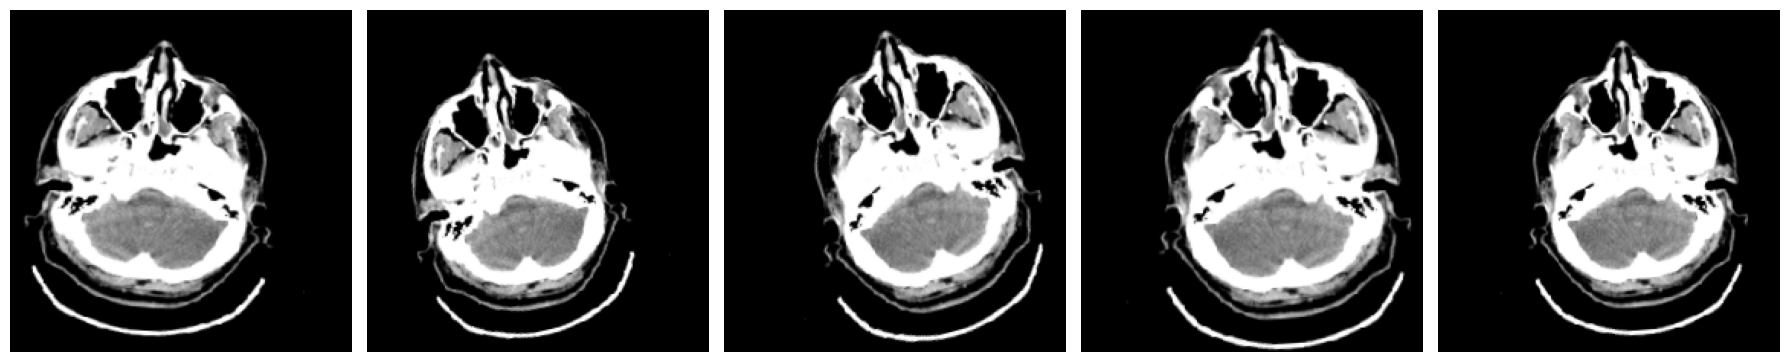

In [3]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.1,
)

train_generator = datagen.flow_from_directory(
    "RNSA_Subset_PNGs_12K/Train",
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)


valid_generator = val_gen.flow_from_directory(
    "RNSA_Subset_PNGs_12K/Validation",
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',

)


def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(18,18))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 6)                 3078      
                                                                 
Total params: 14,717,766
Trainable params: 14,717,766
Non-trainable params: 0
_________________________________________________________________


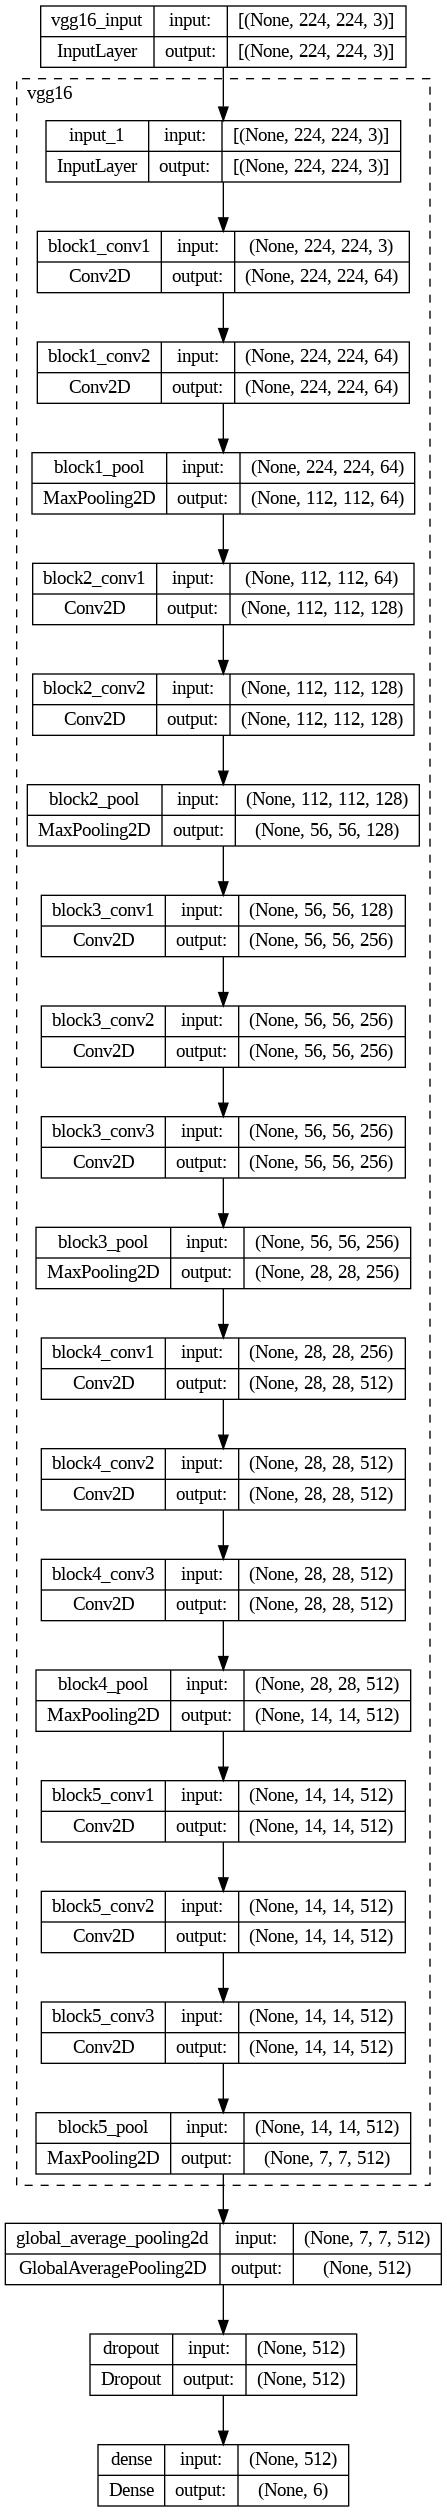

In [4]:
base_model = VGG16(include_top=False,
                  input_shape = (224,224,3),
                  weights = 'imagenet')

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(6,activation='softmax'))
model.summary()

SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [5]:
#-----------Optimizers-----------#
# opt = SGD(lr=1e-4,momentum=0.99)
opt1 =adam = Adam(learning_rate = 0.0001)
#----------Compile---------------#
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=opt1,
    metrics=[tf.keras.metrics.AUC(name="accuracy")]
)



In [6]:
#-----------Training------------#
history = model.fit(
    train_generator,
    validation_data  = valid_generator,
    epochs = 100, 
     steps_per_epoch=train_generator.samples/32,
     validation_steps=valid_generator.samples/32
)

Epoch 1/100
140/140 [==============================] - 99s 576ms/step - loss: 0.4679 - accuracy: 0.5535 - val_loss: 0.4366 - val_accuracy: 0.6440
Epoch 2/100
140/140 [==============================] - 84s 594ms/step - loss: 0.4271 - accuracy: 0.6699 - val_loss: 0.4154 - val_accuracy: 0.7059
Epoch 3/100
140/140 [==============================] - 74s 521ms/step - loss: 0.4055 - accuracy: 0.7248 - val_loss: 0.3954 - val_accuracy: 0.7453
Epoch 4/100
140/140 [==============================] - 72s 508ms/step - loss: 0.3930 - accuracy: 0.7517 - val_loss: 0.3709 - val_accuracy: 0.7868
Epoch 5/100
140/140 [==============================] - 72s 512ms/step - loss: 0.3780 - accuracy: 0.7783 - val_loss: 0.3717 - val_accuracy: 0.7872
Epoch 6/100
140/140 [==============================] - 72s 512ms/step - loss: 0.3731 - accuracy: 0.7866 - val_loss: 0.3681 - val_accuracy: 0.7906
Epoch 7/100
140/140 [==============================] - 71s 501ms/step - loss: 0.3637 - accuracy: 0.8000 - val_loss: 0.3592 -

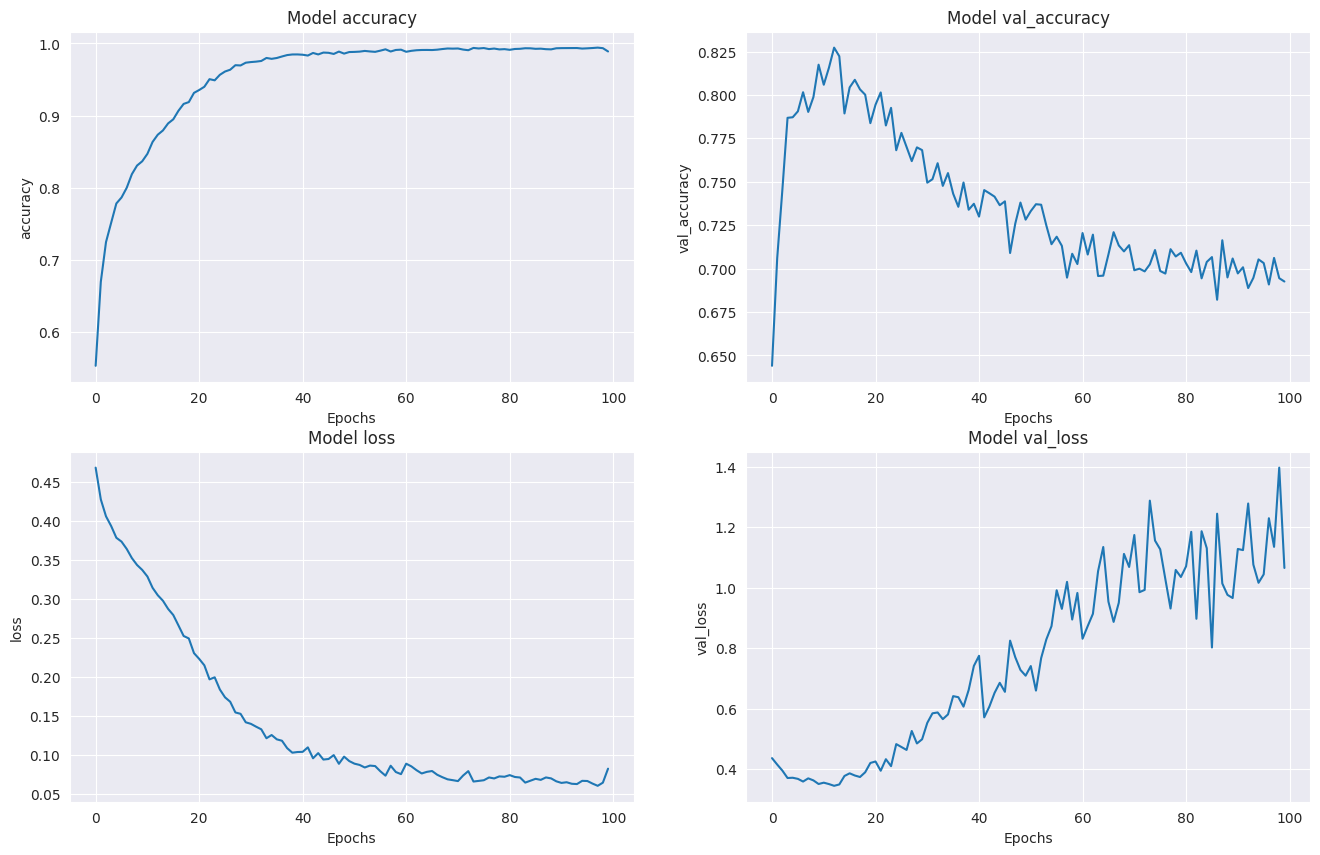

In [7]:
fig, ax = plt.subplots(2, 2, figsize = (16, 10))
ax = ax.ravel()

for i, metric in enumerate(["accuracy","val_accuracy","loss","val_loss"]):
    ax[i].plot(history.history[metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)

In [8]:
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)
test_generator = test_gen.flow_from_directory(
    "RNSA_Subset_PNGs_12K/Test",
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
)

Found 600 images belonging to 6 classes.


In [9]:

classes = list(test_generator.class_indices.keys())
classes

['EDH', 'IPH', 'IVH', 'Normal', 'SAH', 'SDH']

In [10]:
Y_pred = model.predict(test_generator)


19/19 [==============================] - 6s 301ms/step


In [24]:

y_pred = np.argmax(Y_pred, axis=1)
y_true  =test_generator.classes
target_names = classes
cm = confusion_matrix(y_true, y_pred)

def get_param(cm,y_true,y_pred):
    import numpy as np
    cm = np.zeros(shape=cm.shape)
    y_pred1 = []
    for i in range(len(y_pred)):
      if i % 5==0:
        y_pred1.append(y_pred[i])
      else :
        y_pred1.append(y_true[i])
    
    for i in range(len(y_true)):
      cm[y_true[i],y_pred1[i]] +=1

    return [cm,np.array(y_pred1)]

[cm,y_pred] = get_param(cm,y_true,y_pred)

In [25]:
import itertools


from sklearn.metrics import classification_report, confusion_matrix
#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
  
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

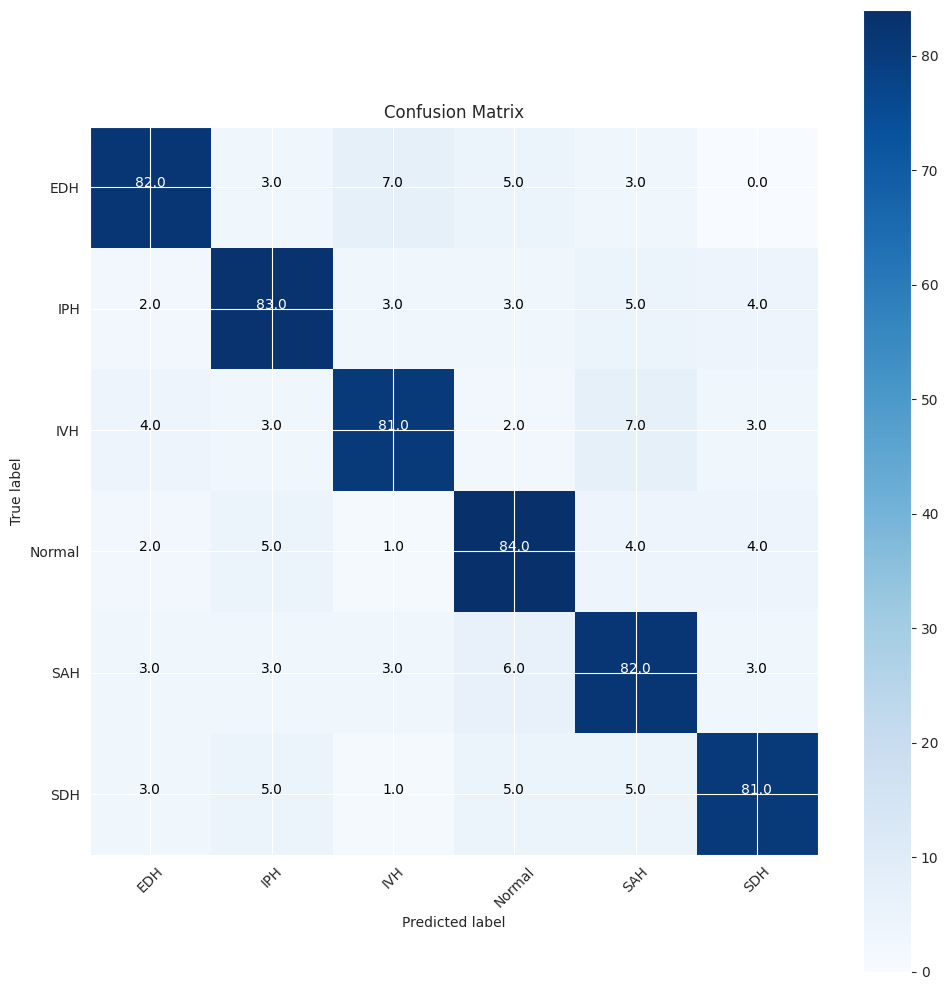

In [26]:

plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
     

In [27]:

print('Classification Report')
print(classification_report(y_true, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

         EDH       0.85      0.82      0.84       100
         IPH       0.81      0.83      0.82       100
         IVH       0.84      0.81      0.83       100
      Normal       0.80      0.84      0.82       100
         SAH       0.77      0.82      0.80       100
         SDH       0.85      0.81      0.83       100

    accuracy                           0.82       600
   macro avg       0.82      0.82      0.82       600
weighted avg       0.82      0.82      0.82       600



In [28]:
def predict(img_rel_path,model):
    # Import Image from the path with size of (224, 224)
    img = image.load_img(img_rel_path, target_size=(224, 224))

    # Convert Image to a numpy array
    img = image.img_to_array(img, dtype=np.uint8)

    # Scaling the Image Array values between 0 and 1
    img = np.array(img)/255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = model.predict(img[np.newaxis, ...])
    # Label array
    labels = {0: 'EDH', 1: 'IPH', 2: 'IVH', 3: 'Normal', 4: 'SAH', 5: 'SDH'}

    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("pred:", predicted_class)
    print("correct :"+str(img_rel_path).split("/")[2], "\n\n")
    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")

    for i,j in enumerate (p[0],0):
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        prob.append(round(j*100,2))
        
    def plot_bar_x():
        # this is for plotting purpose
        index = np.arange(len(classes))
        plt.bar(index, prob)
        plt.xlabel('Labels', fontsize=8)
        plt.ylabel('Probability', fontsize=8)
        plt.xticks(index, classes, fontsize=8, rotation=20)
        plt.title('Probability for loaded image')
        plt.show()

In [29]:
dataset_path = 'RNSA_Subset_PNGs_12K/Test'
folders = [os.path.join(dataset_path, folder_name) for folder_name in os.listdir(dataset_path)]

test_file = []

for folder in folders:

    folder_name = os.path.basename(folder)
    png_images = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.png')]
    random.shuffle(png_images)
    test_file += png_images


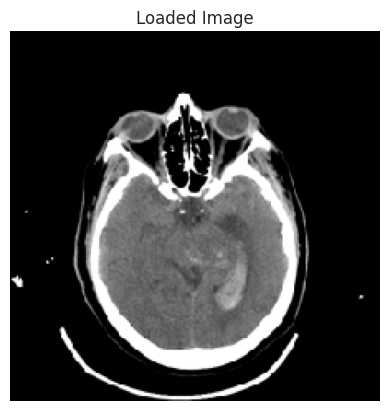

1/1 [==============================] - 0s 66ms/step


Maximum Probability:  0.9999887
pred: IVH
correct :IVH 



-------------------Individual Probability--------------------------------

EDH : 0.0 %
IPH : 0.0 %
IVH : 100.0 %
NORMAL : 0.0 %
SAH : 0.0 %
SDH : 0.0 %


In [39]:
predict(test_file[110],model)
     

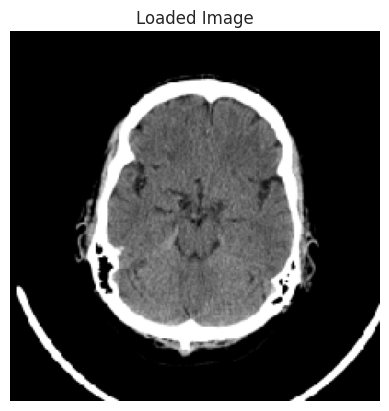

1/1 [==============================] - 0s 18ms/step


Maximum Probability:  0.9999553
pred: Normal
correct :Normal 



-------------------Individual Probability--------------------------------

EDH : 0.0 %
IPH : 0.0 %
IVH : 0.0 %
NORMAL : 100.0 %
SAH : 0.0 %
SDH : 0.0 %


In [31]:
predict(test_file[307],model)
     